# Integrantes:
- Leonardo Bravo
- Felipe Quezada

***

# Practical activity: Regression

***

- In this activity you will explore and analyze a dataset of car gasoline consumption in miles per gallon (MPG) for different brands and types of cars
- We will use data from the [UCI](https://archive.ics.uci.edu/ml/) repository 
- We will use the following libraries: 
    - Python [pandas](https://pandas.pydata.org) to handle data tables
    - matplotlib for visualization
    - [PyMC3](https://docs.pymc.io/) and scikit-learn for the modeling

### Instructions
1. Follow the steps in this notebook, complete the activities and answer the questions marked with a **Q**
1. Pre-process the data and inspect it
1. Train a linear model to predict MPG as a function of other relevant features

In [35]:
import numpy as np
import pandas as pd
import pymc3 as pm
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
%matplotlib notebook
import matplotlib.pylab as plt

***
### Getting the data
- Use the following block to obtain the data
- If you don't have `wget` follow the link, download the data manually and put it on the data folder

In [2]:
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data -P data

El fichero “data/auto-mpg.data” ya está ahí, no se recupera.



*** 
### Pre-process the data

- Import the table as a pandas dataframe and explore it
- **Q:** How many features and samples are in the table?
- **Response**: 7 features. 1 variable corresponde al target (MPG). Hay 398 samplings.
- **Q:** Which variables are continuous and which are categorical?
- **Response**: De los histogramas y tipo de variable (mas abajo), se tiene que "Cylinders" y "Origin" son categoricas. Las demás son continuas.

In this case
- MPG (Miles per gallon) is the variable we want to model (dependent variable) 
- car_name is the index column
- In the original table (auto-mpg.data) there are missing values expressed as "?" that are converted to NaN by pandas
    - **Q:** What features have missing values?
    - **Response**: Horsepower tiene missing values
    - **Q:** Give two cars with missing values

'Describe: '

,MPG,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


'Head: '

,MPG,cylinders,displacement,horsepower,weight,acceleration,model year,origin
car_name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130.0,3504.0,12.0,70,1
buick skylark 320,15.0,8,350.0,165.0,3693.0,11.5,70,1
plymouth satellite,18.0,8,318.0,150.0,3436.0,11.0,70,1
amc rebel sst,16.0,8,304.0,150.0,3433.0,12.0,70,1
ford torino,17.0,8,302.0,140.0,3449.0,10.5,70,1


'Is nan: '

MPG             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
dtype: int64

'Instances with nan: '

,MPG,cylinders,displacement,horsepower,weight,acceleration,model year,origin
car_name,,,,,,,,
ford pinto,25.0,4,98.0,NaN,2046.0,19.0,71,1
ford maverick,21.0,6,200.0,NaN,2875.0,17.0,74,1
renault lecar deluxe,40.9,4,85.0,NaN,1835.0,17.3,80,2
ford mustang cobra,23.6,4,140.0,NaN,2905.0,14.3,80,1
renault 18i,34.5,4,100.0,NaN,2320.0,15.8,81,2
amc concord dl,23.0,4,151.0,NaN,3035.0,20.5,82,1


Feature data type:

MPG: float64
cylinders: int64
displacement: float64
horsepower: float64
weight: float64
acceleration: float64
model year: int64
origin: int64


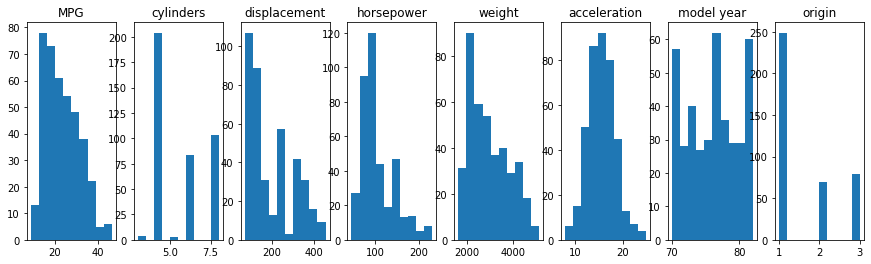

In [3]:
# Use help(pd.read_table) to understand de parameters of read_table

df = pd.read_csv("data/auto-mpg.data", delim_whitespace=True, index_col="car_name",  na_values="?",
                   names= ["MPG", "cylinders", "displacement", "horsepower", 
                           "weight", "acceleration", "model year", "origin", "car_name"])
display("Describe: ", df.describe())
display("Head: ", df.head())
display("Is nan: ", df.isna().sum())
display("Instances with nan: ", df[df.isnull().any(axis=1)])
# You can grab a particular column as: df["MPG"]
# You can obtain a numpy array from it as: df["MPG"].values
fig, ax = plt.subplots(1, 8, figsize = (15,4))
print("Feature data type:\n")
for i in range(8):
    ax[i].hist(df.iloc[:, i])
    ax[i].set_title(df.columns[i])
    print(df.columns[i] + ": " + df.iloc[:, i].dtype.name)

***

### Data inspection

- Inspect the histogram of MPG
- **Q:** Is MPG normal/Gaussian distributed?
- Del histograma, se ve que MPG no tiene distribucion normal
- **Q:** Compute and report the mean, standard deviation and skewness (statistical moments) of MPG 
    - You can use `np.mean()` and `np.std()`
    - You can use `scipy.stats.skew()` for the skewness 

Mean MPG:  23.514572864321615
STD MPG:  7.806159061274433
Skewness MPG:  0.45534192556309266


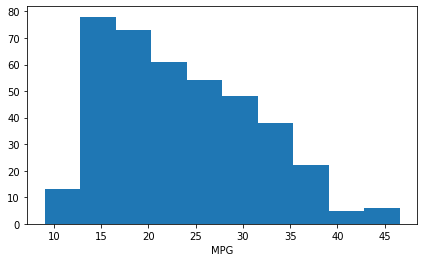

In [4]:
import scipy

plt.close('all'); fig, ax  = plt.subplots(figsize=(7, 4))
ax.hist(df['MPG']); ax.set_xlabel("MPG");
print("Mean MPG: ", np.mean(df["MPG"]))
print("STD MPG: ", np.std(df["MPG"]))
print("Skewness MPG: ", scipy.stats.skew(df["MPG"]))

El valor de skewness difiere del valor de una distirbución normal (valor de 0). Además, como la distribución tiene mas datos hacia la derecha (sesgada hacia la derecha), el valor esperado es mayor que la moda (15 app), por lo que tampoco cumple propiedad de distribución normal.

- Plot MPG as a function of weight, acceleration and horsepower
- **Q:** Describe qualitatively the type of relation between MPG and the other variables (proportional, inversely proportional, linear, polynomial, exponential, etc)
- **Q:** Compute the correlation coefficient $r^2$ for each case 
    - You can use `np.corrcoef(x, y)[0, 1]`
- **Q:** Which feature has the highest correlation with MPG? Which one has the lowest correlation?

Text(0.5, 1.0, 'horsepower R2: -0.7784267838977759')

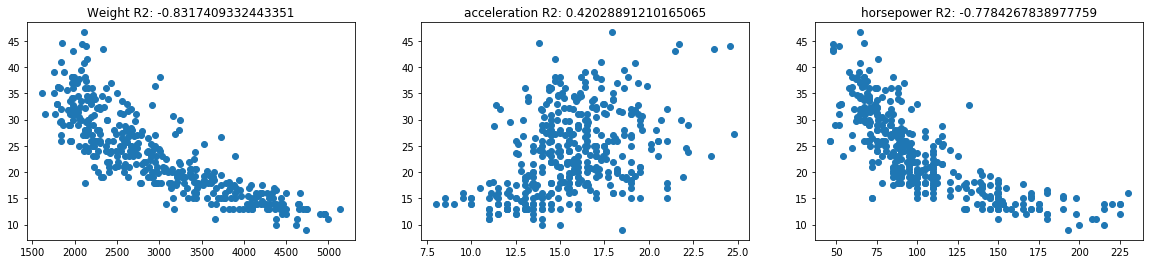

In [5]:
# The following might be useful
mask = ~np.isnan(df["horsepower"].values)

# Note that this is equivalent to
fig, ax  = plt.subplots(1, 3, figsize=(20, 4))
ax[0].scatter(df["weight"].values, df["MPG"].values); 
ax[0].set_title("Weight R2: " + str(np.corrcoef(df["weight"].values, df["MPG"].values)[0, 1]))

ax[1].scatter(df["acceleration"].values, df["MPG"].values); 
ax[1].set_title("acceleration R2: " + str(np.corrcoef(df["acceleration"].values, df["MPG"].values)[0, 1]))

ax[2].scatter(df.loc[mask,"horsepower"].values, df.loc[mask, "MPG"].values); 
ax[2].set_title("horsepower R2: " + str(np.corrcoef(df.loc[mask, "horsepower"].values, df.loc[mask, "MPG"].values)[0, 1]))

Relaciones:
    - Weight con MPG: Inversamente proporcional y al parecer polinomial (quizás segundo orden).
    - Acceleration con MPG: Proporcional y al parecer polinomial (quizás segundo orden). Sin embargo, se observa mucha variabilidad en los datos, lo que dificulta ver claramente el tipo de relación.
    - Horse power con MGP: Inversamente proporcional y al parecer polinomial (quizás segundo orden). 
 
Las variables Weight y horsepower poseen menor variabilidad que Acceleration, por lo que en estas variables es mas clara el tipo de relación.

El que posee mayor valor de correlación con MPG corresponde a Weigth (con -0.83).

El que posee menor valor de correlación con MPG corresponde a acceleration (con 0.42).

### Single independant variable regression

- **Q:** Find the parameters of a simple linear model to predict MPG given weight using MLE assuming a Gaussian likelihood
- **Q:** Propose a polynomial basis of a given degree and find a better regressor for MPG given weight
- In both cases: Plot and study the residuals (errors) between data and your model

Simple linear model
theta0: 46.31736442026565
thetaj: array([-0.00767661])
MSE: 7474.8140143821


Text(0.5, 1.0, 'Residual distribution')

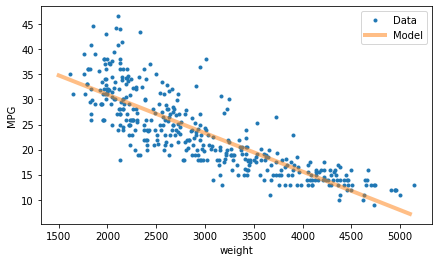

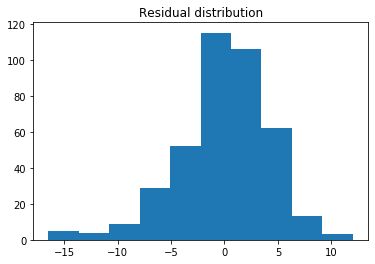

In [12]:
# Simple linear model
print("Simple linear model")

x, y = df["weight"].values, df["MPG"].values
# OLS solution
regressor = make_pipeline(PolynomialFeatures(1), Ridge(normalize=True, alpha=0.))
regressor.fit(x.reshape(-1, 1), y)
# The previous line is equivalent to 
# display(np.ones_like(x).shape)
# display(x.shape)
# degree = 1
# X = np.stack((np.ones_like(x), x**degree)).T
# X = np.stack((np.ones_like(x), x)).T # Dimension Nx2
# param, MSE, rank, singval = np.linalg.lstsq(X, y, rcond=None)
# param = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y).T)
# param = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))
# print("params: ", param)
print("theta0: "+repr(regressor.steps[1][1].intercept_))
print("thetaj: "+repr(regressor.steps[1][1].coef_[1:]))
print("MSE: "+repr(np.sum((y - regressor.predict(x.reshape(-1, 1)))**2)))
plt.close('all'); fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(df["weight"].values, df["MPG"].values, '.', label='Data')
ax.set_xlabel('weight'); ax.set_ylabel('MPG'); 
x_eval = np.linspace(1500, 5100, 100)
ax.plot(x_eval, regressor.predict(x_eval.reshape(-1, 1)), linewidth=4, alpha=0.5, label="Model")
# ax.plot(x_eval, param[0]+param[1]*(x_eval**degree), linewidth=4, alpha=0.5, label="Model")
plt.legend(loc=0);

# plot of residuals
fig, ax = plt.subplots()
ax.hist((regressor.predict(x.reshape(-1, 1))-y))
ax.set_title("Residual distribution")

En este caso, al tener regresor lineal con polinomio de grado 1 (parametro_0 + weigth * paremtro_1), se tiene errores residuales con distribución similar a normal, por lo que se cumple el supuesto de error con distribución gaussiana.

Polynomical linear model
MSE: 6917.12250542243


Text(0.5, 1.0, 'Residual distribution')

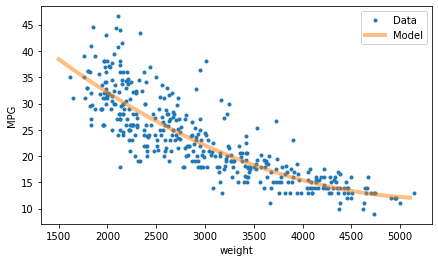

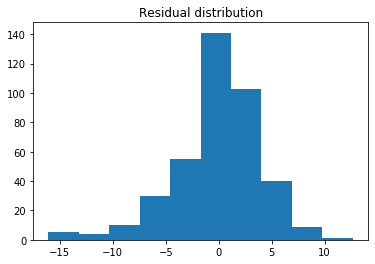

In [7]:
#### Polynomical model
print("Polynomical linear model")

x, y = df["weight"].values, df["MPG"].values
# OLS solution
regressor = make_pipeline(PolynomialFeatures(2), Ridge(normalize=True, alpha=0.))
regressor.fit(x.reshape(-1, 1), y)
# The previous line is equivalent to 
# display(np.ones_like(x).shape)
# display(x.shape)
# degree = 1
# X = np.stack((np.ones_like(x), x**degree)).T
# X = np.stack((np.ones_like(x), x)).T # Dimension Nx2
# param, MSE, rank, singval = np.linalg.lstsq(X, y, rcond=None)
# param = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y).T)
# param = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))
# print("params: ", param)
# print("theta0: "+repr(regressor.steps[1][1].intercept_))
# print("thetaj: "+repr(regressor.steps[1][1].coef_[1:]))
print("MSE: "+repr(np.sum((y - regressor.predict(x.reshape(-1, 1)))**2)))
plt.close('all'); fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(df["weight"].values, df["MPG"].values, '.', label='Data')
ax.set_xlabel('weight'); ax.set_ylabel('MPG'); 
x_eval = np.linspace(1500, 5100, 100)
ax.plot(x_eval, regressor.predict(x_eval.reshape(-1, 1)), linewidth=4, alpha=0.5, label="Model")
# ax.plot(x_eval, param[0]+param[1]*(x_eval**degree), linewidth=4, alpha=0.5, label="Model")
plt.legend(loc=0);

# plot of residuals
fig, ax = plt.subplots()
ax.hist((regressor.predict(x.reshape(-1, 1))-y))
ax.set_title("Residual distribution")

En este casos se analizan varios grados polinomicos, y se tenían que grados entre 2 y 4 tenían similares valores de MSE (en torno a 6917). Sin embargo, al aumentar el grado sobre 4, se tienen menores valores, pero con se observa overfitting. Por lo que se define que mejor grado corresponde a grado 2. 

Errores residuales tienen distribución similar a normal con media en 0, por lo que se cumple supuesto de error distribuido normal.

- **Q:** Find the parameters of a linear model to predict MPG from weight using the Bayesian approach assuming a Gaussian likelihood and Gaussian prior
- **Q:** Extend using the best polynomial found in the previous step

$$
p(y|X, \theta) =  \mathcal{N}(X\theta, I\sigma^2)
$$
$$
p(\theta) =  \mathcal{N}(0, I\sigma_0^2)
$$

References:
- https://docs.pymc.io/notebooks/GLM-linear.html
- https://www.chrisstucchio.com/blog/2017/bayesian_linear_regression.html

In [8]:
x, y = df["weight"].values, df["MPG"].values
with pm.Model() as bayesian_linear_model:
    
    #priors
    theta_0 = pm.Normal("thehta_0", 0, sd = 20)
    theta_1 = pm.Normal("thehta_1", 0, sd = 20)
    sigma = pm.HalfCauchy("sigma_noise", beta = 10, testval = 1.)
    
    # Likelihood
    likelihood = pm.Normal("y", mu = theta_0 + theta_1*x, sd = sigma, observed = y)
    
    # trace
    trace = pm.sample(draws = 5000, tune = 2000, init = "advi", n_init = 300000, cores = 8, chains = 2)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 1,595.4:  14%|█▎        | 41200/300000 [00:10<01:05, 3949.49it/s]   
Convergence achieved at 41500
Interrupted at 41,499 [13%]: Average Loss = 9.3687e+07
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [sigma_noise, thehta_1, thehta_0]
Sampling 2 chains: 100%|██████████| 14000/14000 [00:13<00:00, 1038.65draws/s]


In [9]:
pm.summary(trace)

/home/leo/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
thehta_0,46.273160,0.811541,0.012726,44.703855,47.853638,3876.830038,0.999900
thehta_1,-0.007664,0.000263,0.000004,-0.008190,-0.007164,3856.751560,0.999909
sigma_noise,4.354763,0.155888,0.002075,4.058891,4.671125,5991.463668,1.000050


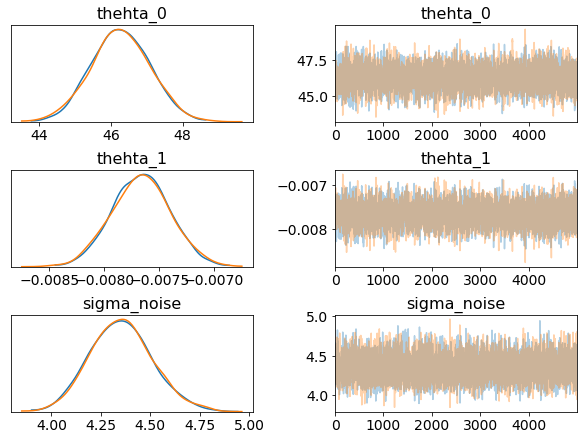

In [10]:
plt.close('all'); pm.traceplot(trace, figsize=(8, 6));

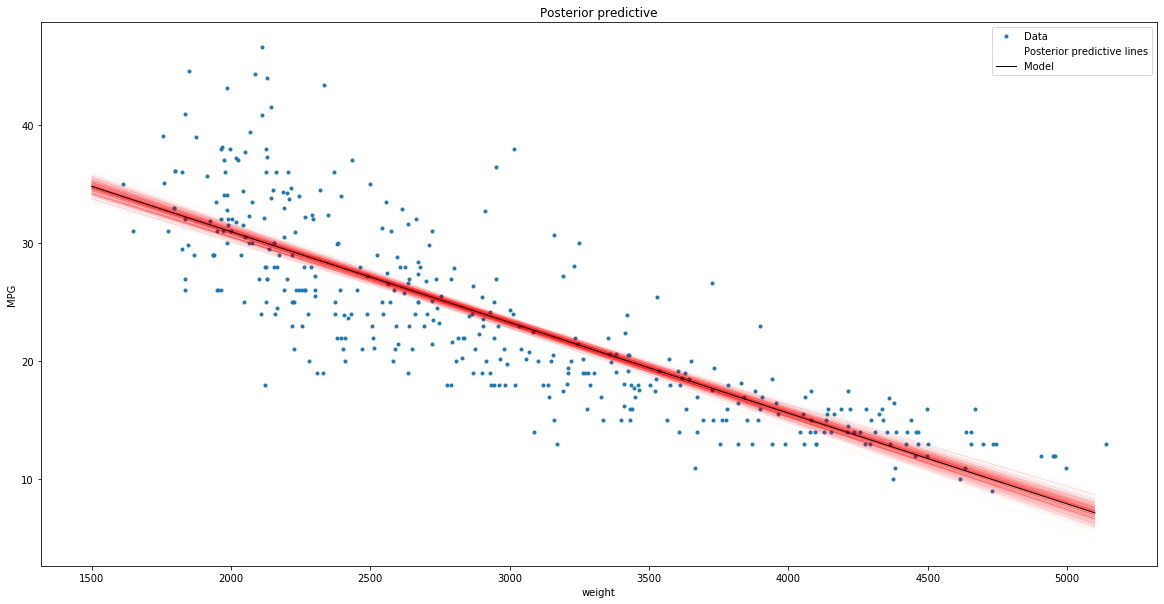

In [20]:
plt.close('all'); fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df["weight"].values, df["MPG"].values, '.', label='Data')
ax.set_xlabel('weight'); ax.set_ylabel('MPG');
pm.plot_posterior_predictive_glm(trace, samples=500, label='Posterior predictive lines', c='r', alpha=0.1,
                                 lm= lambda x, sample: sample['thehta_0'] + sample['thehta_1'] *x,
                                 eval=np.linspace(1500, 5100, 100))
ax.plot(x_eval, regressor.predict(x_eval.reshape(-1, 1)), linewidth=1, alpha=1, label="Model", c = "black")
plt.legend(loc=0);

### Multiple independent variables

- **Q:** Find the parameters of a linear model to predict MPG from weight and acceleration assuming a Gaussian likelihood. Use the Frequentist and Bayesian approaches

# Bayesian approach for Multivariable linear regressor

<IPython.core.display.Javascript object>


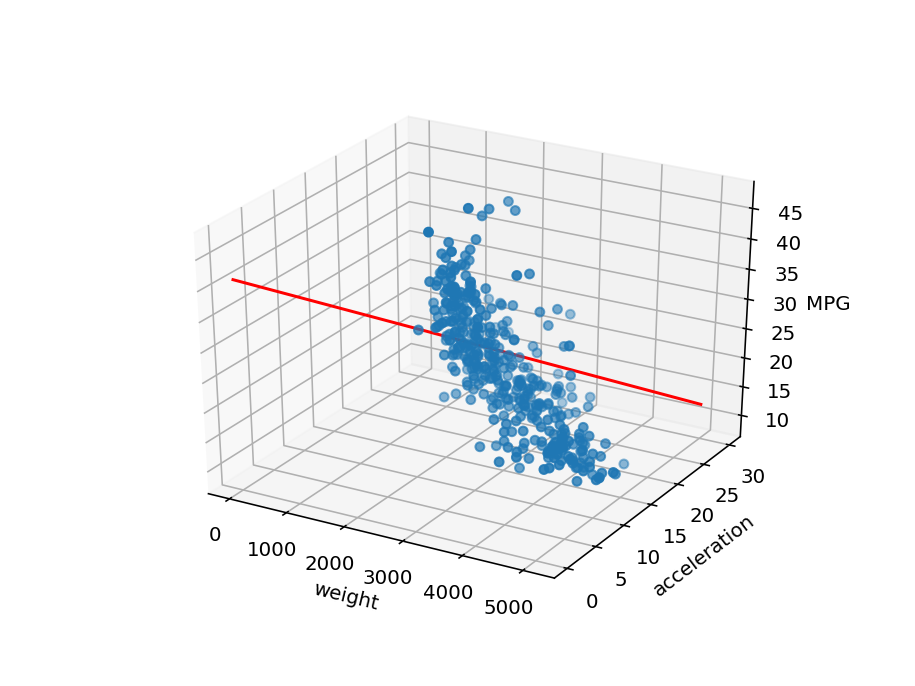

params:  [ 4.13998283e+01 -7.33564480e-03  2.50815893e-01]


<IPython.core.display.Javascript object>


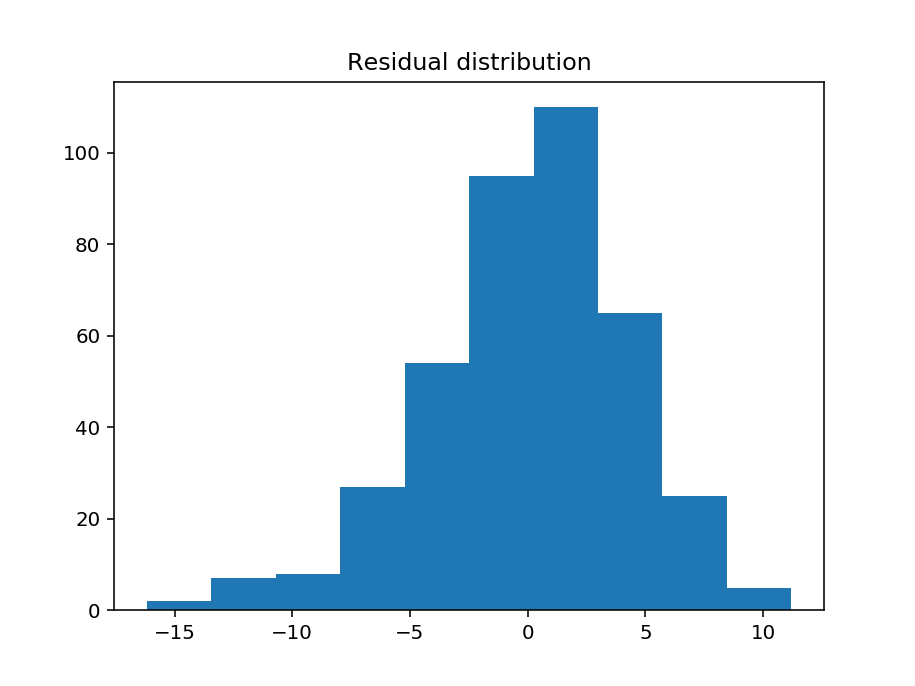

Text(0.5, 1.0, 'Residual distribution')

In [61]:
# Multiple linear model for frequentist approach
from mpl_toolkits import mplot3d

x, y = df[["weight", "acceleration"]].values, df["MPG"].values

fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.scatter(x[:, 0], x[:, 1])
ax.scatter3D(x[:, 0], x[:, 1], y, 'gray')
ax.set_xlabel("weight")
ax.set_ylabel("acceleration")
ax.set_zlabel("MPG")

# OLS solution
# regressor = make_pipeline(PolynomialFeatures(1), Ridge(normalize=True, alpha=0.))
# regressor.fit(x.reshape(-1, 2), y)
# The previous line is equivalent to 
# display(np.ones_like(x).shape)
# display(x.shape)
# degree = 1
# X = np.stack((np.ones_like(x), x**degree)).T
X = np.stack((np.ones_like(x[:, 0]), x[:, 0], x[:, 1])).T # Dimension Nx3
param, MSE, rank, singval = np.linalg.lstsq(X, y, rcond=None)
# param = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y).T)
# param = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))
print("params: ", param)
# print("theta0: "+repr(regressor.steps[1][1].intercept_))
# print("thetaj: "+repr(regressor.steps[1][1].coef_[1:]))
# print("MSE: "+repr(np.sum((y - regressor.predict(x.reshape(-1, 1)))**2)))
# plt.close('all'); fig, ax = plt.subplots(figsize=(7, 4))
# ax.set_xlabel('weight'); ax.set_ylabel('MPG'); 
x1_eval = np.linspace(0, 5000, 100)
x2_eval = np.linspace(0, 30, 100)

# ax.plot(x1_eval, regressor.predict(x_eval.reshape(-1, 1)), linewidth=4, alpha=0.5, label="Model")
# ax.plot(x_eval, param[0]+param[1]*(x_eval**degree), linewidth=4, alpha=0.5, label="Model")
ax.plot3D(x1_eval, x2_eval, param[0] + param[1]*x1_eval + param[2]*x2_eval, 'red')
# plt.legend(loc=0);

# plot of residuals
fig, ax = plt.subplots()
ax.hist((param[0] + x[:,0]*param[1] + x[:, 1]*param[2])-y)
ax.set_title("Residual distribution")

Desde gráfico de residuales, se observa distribución similar a normal, cumpliendose el supuesto de error con distribución normal con valor esperado 0.

# Bayesian approach for Multivariable linear regressor

In [62]:
x, y = df[["weight", "acceleration"]].values, df["MPG"].values

with pm.Model() as bayesian_linear_model:
    
    
    #priors
    theta_0 = pm.Normal("thehta_0", 0, sd = 20)
    theta_1 = pm.Normal("thehta_1", 0, sd = 20)
    theta_2 = pm.Normal("thehta_2", 0, sd = 20)
    sigma = pm.HalfCauchy("sigma_noise", beta = 10, testval = 1.)
    
    # Likelihood
    likelihood = pm.Normal("y", mu = theta_0 + theta_1*x[:, 0] + theta_2*x[:, 1], sd = sigma, observed = y)
    
    # trace
    trace = pm.sample(draws = 5000, tune = 2000, init = "advi", n_init = 300000, cores = 8, chains = 2)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 1,321.8:  17%|█▋        | 50554/300000 [00:13<01:05, 3796.40it/s]   
Convergence achieved at 50700
Interrupted at 50,699 [16%]: Average Loss = 7.6291e+07
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [sigma_noise, thehta_2, thehta_1, thehta_0]
Sampling 2 chains: 100%|██████████| 14000/14000 [00:22<00:00, 632.40draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [63]:
pm.summary(trace)

/home/leo/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
thehta_0,41.053714,1.853359,0.042059,37.406225,44.583635,2384.489280,1.000336
thehta_1,-0.007303,0.000277,0.000005,-0.007845,-0.006765,3576.038424,0.999902
thehta_2,0.266462,0.086596,0.001900,0.102027,0.439391,2562.032376,1.000706
sigma_noise,4.315711,0.155614,0.001506,4.014429,4.619948,10101.073715,0.999970


<IPython.core.display.Javascript object>


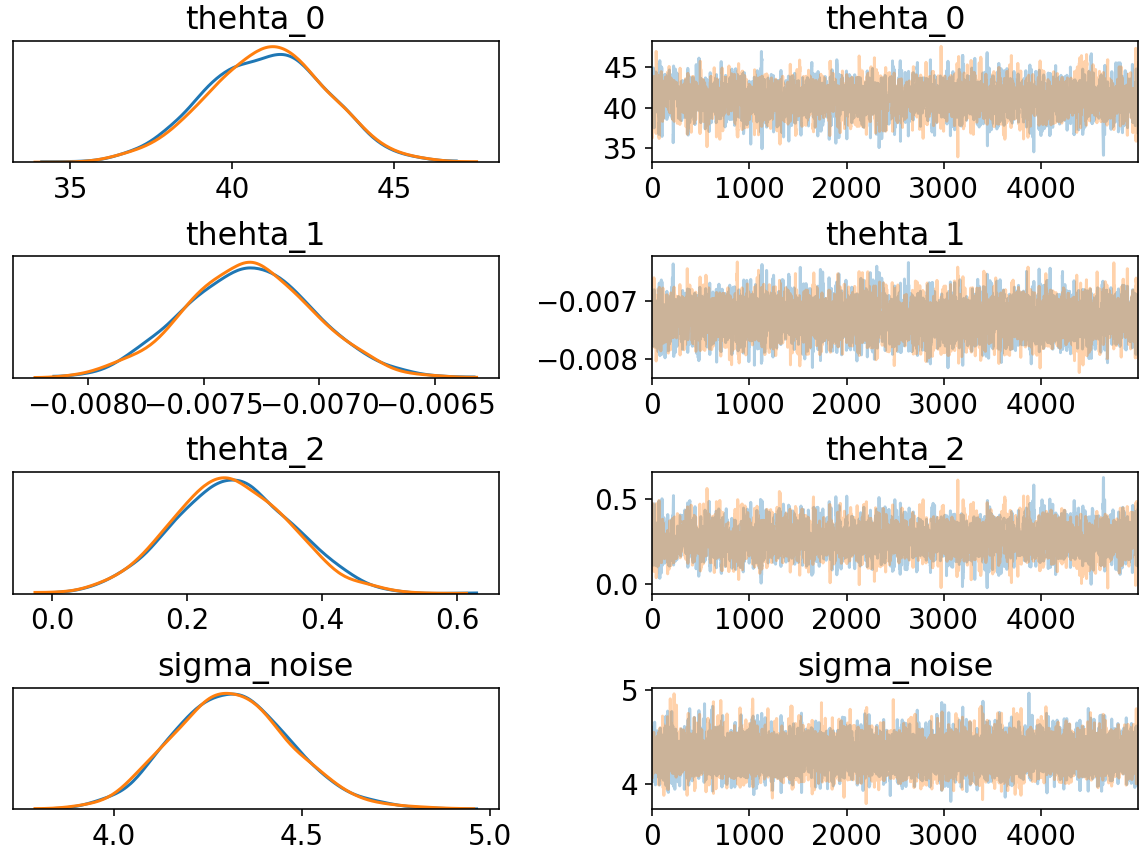

In [64]:
plt.close('all'); pm.traceplot(trace, figsize=(8, 6));

Follow-up: http://twiecki.github.io/blog/2013/08/12/bayesian-glms-1/

Dada la naturaleza del enfoque Bayesiano, se obentiene finalmente las distribuciones de cada uno de los parámetros del regresor. Se observa distrubción similar a normal para los parámetros y centrados en el estimador MLE obtenido a partir de enfoque frecuentista (valores obtenidos mediante MLE).